## FLIGHT STATUS PREDICTOR PROJECT - Notebook 2

#### The goal of this project is to develop and deploy an ML model in which an end user can specify a set of features describing a commercial flight of interest and receive a categorical (yes or no) output indicating if the arrival time of that flight will be delayed more than fifteen minutes or not. 

### MODEL TRAINING & EVALUATION

In [149]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import time
import shap
import re

### Checking dataset

In [151]:
# Load the dataset
df = pd.read_csv('selected_features.csv')

# Define the target variable
target = 'Arr_Delay_At_Least_15_Minutes'

# Split the data into features and target variable
X = df.drop(columns=[target])
y = df[target]

# Check the loaded data
print(X.head())
print(y.head())

   Arr_Hour  Dep_Hour  Dep_Time_Day_Interaction  Distance_Miles  Is_Weekend  \
0         7       6.0                    3000.0        7.393263    0.693147   
1        12      21.0                       0.0        6.951772    0.000000   
2        14      13.0                    2610.0        6.066108    0.000000   
3        17      15.0                    9030.0        7.025538    0.693147   
4        10      21.0                    8508.0        6.766192    0.000000   

   Month  Number_of_Flights  Scheduled_Arrival_Time  Scheduled_Departure_Time  \
0      5                  1                   703.0                     600.0   
1      5                  1                   125.0                    2100.0   
2      5                  1                  1430.0                    1305.0   
3      6                  1                  1720.0                    1505.0   
4      6                  1                   100.0                    2127.0   

   Scheduled_Gate_to_Gate_Time  Week_D

In [152]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742902 entries, 0 to 2742901
Data columns (total 15 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Arr_Hour                       int64  
 1   Dep_Hour                       float64
 2   Dep_Time_Day_Interaction       float64
 3   Distance_Miles                 float64
 4   Is_Weekend                     float64
 5   Month                          int64  
 6   Number_of_Flights              int64  
 7   Scheduled_Arrival_Time         float64
 8   Scheduled_Departure_Time       float64
 9   Scheduled_Gate_to_Gate_Time    float64
 10  Week_Day                       int64  
 11  Carrier_Name                   object 
 12  Destination_City_State         object 
 13  Origin_City_State              object 
 14  Arr_Delay_At_Least_15_Minutes  int64  
dtypes: float64(7), int64(5), object(3)
memory usage: 313.9+ MB
None


In [153]:
print(df.head())

   Arr_Hour  Dep_Hour  Dep_Time_Day_Interaction  Distance_Miles  Is_Weekend  \
0         7       6.0                    3000.0        7.393263    0.693147   
1        12      21.0                       0.0        6.951772    0.000000   
2        14      13.0                    2610.0        6.066108    0.000000   
3        17      15.0                    9030.0        7.025538    0.693147   
4        10      21.0                    8508.0        6.766192    0.000000   

   Month  Number_of_Flights  Scheduled_Arrival_Time  Scheduled_Departure_Time  \
0      5                  1                   703.0                     600.0   
1      5                  1                   125.0                    2100.0   
2      5                  1                  1430.0                    1305.0   
3      6                  1                  1720.0                    1505.0   
4      6                  1                   100.0                    2127.0   

   Scheduled_Gate_to_Gate_Time  Week_D

### Preprocessing selected features

In [155]:
# Split data into training and test sets
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data split took: %s seconds" % (time.time() - start_time))

Data split took: 1.6073250770568848 seconds


In [156]:
# Define numerical and categorical features
numerical_features = ['Arr_Hour', 'Dep_Hour', 'Dep_Time_Day_Interaction', 'Distance_Miles', 'Is_Weekend', 'Month', 'Number_of_Flights', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Scheduled_Gate_to_Gate_Time', 'Week_Day']
categorical_features = ['Carrier_Name', 'Destination_City_State', 'Origin_City_State']

In [157]:
# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

In [158]:
# Fit the preprocessor on the training data 
start_time = time.time()
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
print("Preprocessing took: %s seconds" % (time.time() - start_time))

Preprocessing took: 3.983208656311035 seconds


In [159]:
# Convert sparse matrices to dense DataFrames for inspection
from scipy.sparse import csr_matrix
start_time = time.time()
if isinstance(X_train_preprocessed, csr_matrix):
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed.toarray())
if isinstance(X_test_preprocessed, csr_matrix):
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed.toarray())    
print("Conversion took: %s seconds" % (time.time() - start_time))

Conversion took: 2.4689178466796875 seconds


In [160]:
# Inspect the preprocessed data
print("Sample of X_train_preprocessed:")
print(X_train_preprocessed.head())

print("Sample of X_test_preprocessed:")
print(X_test_preprocessed.head())

Sample of X_train_preprocessed:
        0         1         2         3         4         5    6         7    \
0 -1.200961 -1.364394  0.049769 -1.247270  1.582973 -0.733002  0.0 -1.106118   
1 -1.006231 -1.157840 -0.541096  0.659158 -0.631723 -1.031176  0.0 -0.993604   
2 -0.616771 -0.744733  0.001584  0.357981 -0.631723 -1.627525  0.0 -0.564178   
3  0.551609  0.907696  1.452546 -0.892536  1.582973  0.161521  0.0  0.575960   
4  0.356879 -0.125072  1.148380  0.756575  1.582973  0.757870  0.0  0.362184   

        8         9    ...  697  698  699  700  701  702  703  704  705  706  
0 -1.337583 -1.236775  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1 -1.178226  0.629084  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2 -0.671552  0.381605  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.864814 -0.747551  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4 -0.095415  0.541124  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 70

In [161]:
# Check for non-numeric values and missing values
print("Data types in X_test_preprocessed after conversion:", X_test_preprocessed.dtypes)
missing_values = X_test_preprocessed.isnull().sum().sum()
print(f"Number of missing values: {missing_values}")

if missing_values > 0:
    print("There are missing values in the preprocessed data!")
else:
    print("No missing values in the preprocessed data.")

Data types in X_test_preprocessed after conversion: 0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
702    float64
703    float64
704    float64
705    float64
706    float64
Length: 707, dtype: object
Number of missing values: 0
No missing values in the preprocessed data.


### Model Training

In [163]:
start_time = time.time()

# Use a sample of the training data
sample_size = 10000
X_train_sample = X_train_preprocessed[:sample_size]
y_train_sample = y_train[:sample_size]

# Train RandomForest model
rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_model.fit(X_train_sample, y_train_sample)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_sample, y_train_sample)

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_sample, y_train_sample)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_sample, y_train_sample)

# Train LightGBM model with updated parameters
lgb_params = {
    'random_state': 42,
    'force_row_wise': True  # Force row-wise computation to avoid the overhead warning
    }

lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train_sample, y_train_sample)

print("Model training took: %s seconds" % (time.time() - start_time))

[LightGBM] [Info] Number of positive: 4952, number of negative: 5048
[LightGBM] [Info] Total Bins 1688
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495200 -> initscore=-0.019201
[LightGBM] [Info] Start training from score -0.019201
Model training took: 28.213294744491577 seconds


### Model Evaluation

In [165]:
# Model evaluation
start_time = time.time()

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {roc_auc}')

    return y_pred_proba

# Evaluate RandomForest
print("RandomForest Model Evaluation:")
rf_proba = evaluate_model(rf_model, X_test_preprocessed, y_test)

# Evaluate Logistic Regression
print("Logistic Regression Model Evaluation:")
lr_proba = evaluate_model(lr_model, X_test_preprocessed, y_test)

# Evaluate Gradient Boosting
print("Gradient Boosting Model Evaluation:")
gb_proba = evaluate_model(gb_model, X_test_preprocessed, y_test)

# Evaluate XGBoost model
print("XGBoost Model Evaluation:")
xgb_proba = evaluate_model(xgb_model, X_test_preprocessed, y_test)

# Evaluate LightGBM model
print("LightGBM Model Evaluation:")
lgb_proba = evaluate_model(lgb_model, X_test_preprocessed, y_test)

print("Model evaluation took: %s seconds" % (time.time() - start_time))

RandomForest Model Evaluation:
Accuracy: 0.6060545297777357
Precision: 0.6108597974839843
Recall: 0.5843778482627876
F1 Score: 0.5973254529159345
ROC-AUC: 0.6447437089226938
Logistic Regression Model Evaluation:
Accuracy: 0.6011035744949241
Precision: 0.6036850507928317
Recall: 0.5886506981661744
F1 Score: 0.5960730891981342
ROC-AUC: 0.6361864206228798
Gradient Boosting Model Evaluation:
Accuracy: 0.6171741274305891
Precision: 0.6226319344019597
Recall: 0.5949177877428998
F1 Score: 0.6084594431839156
ROC-AUC: 0.6616924418879655
XGBoost Model Evaluation:
Accuracy: 0.6080287140823324
Precision: 0.6125900538042983
Recall: 0.5877684202850997
F1 Score: 0.5999225997551473
ROC-AUC: 0.6472455604679793
LightGBM Model Evaluation:
Accuracy: 0.6162061755693325
Precision: 0.6230703888181011
Recall: 0.5883152867403113
F1 Score: 0.6051942694269427
ROC-AUC: 0.6601234482851497
Model evaluation took: 34.22263216972351 seconds


## Hyperparameter tuning

In [180]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [182]:
# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier(random_state=42)

In [184]:
# Create pipelines
def create_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('classifier', model)
    ])

rf_pipeline = create_pipeline(rf_model)
lr_pipeline = create_pipeline(lr_model)
gb_pipeline = create_pipeline(gb_model)
xgb_pipeline = create_pipeline(xgb_model)
lgb_pipeline = create_pipeline(lgb_model)

In [186]:
# Initialize and fit GridSearchCV for Random Forest
start_time = time.time()
param_grid_rf = {
    'classifier__n_estimators': [50, 100],  
    'classifier__max_depth': [5, 7]         
}
grid_search_rf = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid_rf, cv=2, n_jobs=-1, scoring='roc_auc', verbose=2)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
rf_model_best = grid_search_rf.best_estimator_
print("Best parameters for RandomForest:", best_params_rf)
print("GridSearchCV for Random Forest took: %s seconds" % (time.time() - start_time))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best parameters for RandomForest: {'classifier__max_depth': 7, 'classifier__n_estimators': 100}
GridSearchCV for Random Forest took: 315.2422204017639 seconds


In [188]:
# Initialize GridSearchCV for Logistic Regression
start_time = time.time()
param_grid_lr = {
    'classifier__C': [0.1, 1],              
    'classifier__penalty': ['l2'],          
    'classifier__solver': ['liblinear']     
}
grid_search_lr = GridSearchCV(estimator=lr_pipeline, param_grid=param_grid_lr, cv=2, n_jobs=-1, scoring='roc_auc', verbose=2)
grid_search_lr.fit(X_train, y_train)
best_params_lr = grid_search_lr.best_params_
lr_model_best = grid_search_lr.best_estimator_
print("Best parameters for Logistic Regression:", best_params_lr)
print("GridSearchCV for Logistic Regression took: %s seconds" % (time.time() - start_time))

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
GridSearchCV for Logistic Regression took: 151.59146308898926 seconds


In [190]:
# Initialize GridSearchCV for Gradient Boosting
start_time = time.time()
param_grid_gb = {
    'classifier__n_estimators': [50, 100],  
    'classifier__max_depth': [3, 5],        
    'classifier__learning_rate': [0.1, 0.2] 
}
grid_search_gb = GridSearchCV(estimator=gb_pipeline, param_grid=param_grid_gb, cv=2, n_jobs=-1, scoring='roc_auc', verbose=2)
grid_search_gb.fit(X_train, y_train)
best_params_gb = grid_search_gb.best_params_
gb_model_best = grid_search_gb.best_estimator_
print("Best parameters for Gradient Boosting:", best_params_gb)
print("GridSearchCV for Gradient Boosting took: %s seconds" % (time.time() - start_time))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
GridSearchCV for Gradient Boosting took: 4339.017239809036 seconds


In [192]:
# Initialize GridSearchCV for XGBoost
start_time = time.time()
param_grid_xgb = {
    'classifier__n_estimators': [50, 100],  
    'classifier__max_depth': [3, 5],        
    'classifier__learning_rate': [0.1, 0.2] 
}
grid_search_xgb = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid_xgb, cv=2, n_jobs=-1, scoring='roc_auc', verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
xgb_model_best = grid_search_xgb.best_estimator_
print("Best parameters for XGBoost:", best_params_xgb)
print("GridSearchCV for XGBoost took: %s seconds" % (time.time() - start_time))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters for XGBoost: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
GridSearchCV for XGBoost took: 112.81880283355713 seconds


In [194]:
# Initialize GridSearchCV for LightGBM
start_time = time.time()

# Ensure num_leaves is appropriately set for LightGBM
num_leaves = max(2 ** best_params_lgb_cleaned['max_depth'], best_params_lgb_cleaned.get('num_leaves', 31))

param_grid_lgb = {
    'classifier__n_estimators': [50, 100],  
    'classifier__max_depth': [3, 5],        
    'classifier__learning_rate': [0.1, 0.2],
    'classifier__num_leaves': [31, 63]      # Added explicit num_leaves 
    }
grid_search_lgb = GridSearchCV(estimator=lgb_pipeline, param_grid=param_grid_lgb, cv=2, n_jobs=-1, scoring='roc_auc', verbose=2)
grid_search_lgb.fit(X_train, y_train)
best_params_lgb = grid_search_lgb.best_params_
lgb_model_best = grid_search_lgb.best_estimator_
print("Best parameters for LightGBM:", best_params_lgb)
print("GridSearchCV for LightGBM took: %s seconds" % (time.time() - start_time))

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1097161, number of negative: 1097160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2720
[LightGBM] [Info] Number of data points in the train set: 2194321, number of used features: 698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000001
[LightGBM] [Info] Start training from score 0.000001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [196]:
# Best parameters obtained from GridSearchCV
best_params_rf = {'classifier__max_depth': 7, 'classifier__n_estimators': 100}
best_params_lr = {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
best_params_gb = {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
best_params_xgb = {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
best_params_lgb = {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__num_leaves': 31}

In [202]:
# Function to create a pipeline for retraining
def create_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

# Clean the best parameters
def clean_params(params):
    return {key.split('__')[1]: value for key, value in params.items()}

best_params_rf_cleaned = clean_params(best_params_rf)
best_params_lr_cleaned = clean_params(best_params_lr)
best_params_gb_cleaned = clean_params(best_params_gb)
best_params_xgb_cleaned = clean_params(best_params_xgb)
best_params_lgb_cleaned = clean_params(best_params_lgb)

# Initialize the models with the cleaned parameters
rf_model_best = RandomForestClassifier(random_state=42, **best_params_rf_cleaned)
lr_model_best = LogisticRegression(max_iter=1000, random_state=42, **best_params_lr_cleaned)
gb_model_best = GradientBoostingClassifier(random_state=42, **best_params_gb_cleaned)
xgb_model_best = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_params_xgb_cleaned)
# Ensure num_leaves is appropriately set for LightGBM
num_leaves = max(2 ** best_params_lgb_cleaned['max_depth'], best_params_lgb_cleaned.get('num_leaves', 31))

# Add other relevant parameters to avoid warnings
best_params_lgb_cleaned.update({
    'num_leaves': num_leaves,
    'min_gain_to_split': 0.01,
    'force_row_wise': True
})

lgb_model_best = lgb.LGBMClassifier(random_state=42, **best_params_lgb_cleaned)

# Create pipelines for each model
rf_pipeline_best = create_pipeline(rf_model_best)
lr_pipeline_best = create_pipeline(lr_model_best)
gb_pipeline_best = create_pipeline(gb_model_best)
xgb_pipeline_best = create_pipeline(xgb_model_best)
lgb_pipeline_best = create_pipeline(lgb_model_best)

# Function to fit and save the model 
def fit_and_save_model(pipeline, X_train, y_train, model_name):
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    print(f"{model_name} retraining took: {elapsed_time} seconds")
    joblib.dump(pipeline, f'{model_name}_best_model.pkl')
    return elapsed_time

# Retrain and save the models
total_time = 0
print("Starting retraining of models...")

# RandomForest
total_time += fit_and_save_model(rf_pipeline_best, X_train, y_train, "RandomForest") 

# LogisticRegression
total_time += fit_and_save_model(lr_pipeline_best, X_train, y_train, "LogisticRegression")

# GradientBoosting
total_time += fit_and_save_model(gb_pipeline_best, X_train, y_train, "GradientBoosting")

# XGBoost
total_time += fit_and_save_model(xgb_pipeline_best, X_train, y_train, "XGBoost")

# LightGBM
total_time += fit_and_save_model(lgb_pipeline_best, X_train, y_train, "LightGBM")

print(f"Total retraining and saving time: {total_time} seconds")

Starting retraining of models...
RandomForest retraining took: 162.9143853187561 seconds
LogisticRegression retraining took: 65.24126505851746 seconds
GradientBoosting retraining took: 1440.8312799930573 seconds
XGBoost retraining took: 16.171340227127075 seconds
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Info] Number of positive: 1097161, number of negative: 1097160
[LightGBM] [Info] Total Bins 2720
[LightGBM] [Info] Number of data points in the train set: 2194321, number of used features: 698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000001
[LightGBM] [Info] Start training from score 0.000001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [203]:
# Function to load and evaluate the saved models
def load_and_evaluate_model(file_path, X_test, y_test):
    model = joblib.load(file_path)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc

# Final evaluation
roc_auc_rf = load_and_evaluate_model('RandomForest_best_model.pkl', X_test, y_test)
roc_auc_lr = load_and_evaluate_model('LogisticRegression_best_model.pkl', X_test, y_test)
roc_auc_gb = load_and_evaluate_model('GradientBoosting_best_model.pkl', X_test, y_test)
roc_auc_xgb = load_and_evaluate_model('XGBoost_best_model.pkl', X_test, y_test)
roc_auc_lgb = load_and_evaluate_model('LightGBM_best_model.pkl', X_test, y_test)

print("ROC-AUC for RandomForest:", roc_auc_rf)
print("ROC-AUC for Logistic Regression:", roc_auc_lr)
print("ROC-AUC for Gradient Boosting:", roc_auc_gb)
print("ROC-AUC for XGBoost:", roc_auc_xgb)
print("ROC-AUC for LightGBM:", roc_auc_lgb)

[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
ROC-AUC for RandomForest: 0.6549065064342086
ROC-AUC for Logistic Regression: 0.6573096808939713
ROC-AUC for Gradient Boosting: 0.6961440309226189
ROC-AUC for XGBoost: 0.6955403750782878
ROC-AUC for LightGBM: 0.6948619515834559


## SHAP interpretation

SHAP Summary Plot for RandomForest:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


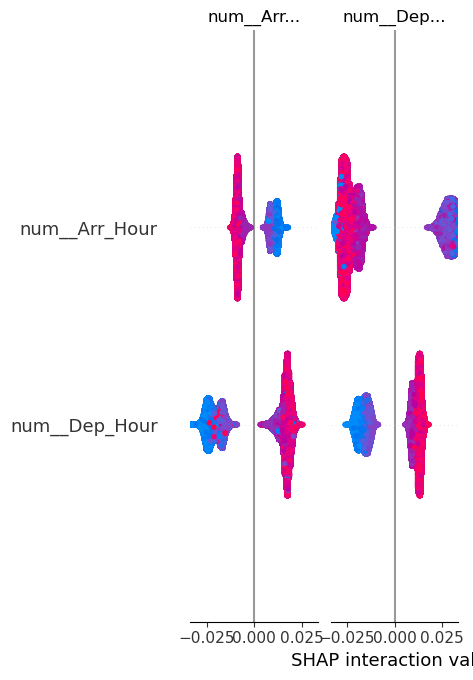

SHAP Summary Plot for Logistic Regression:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


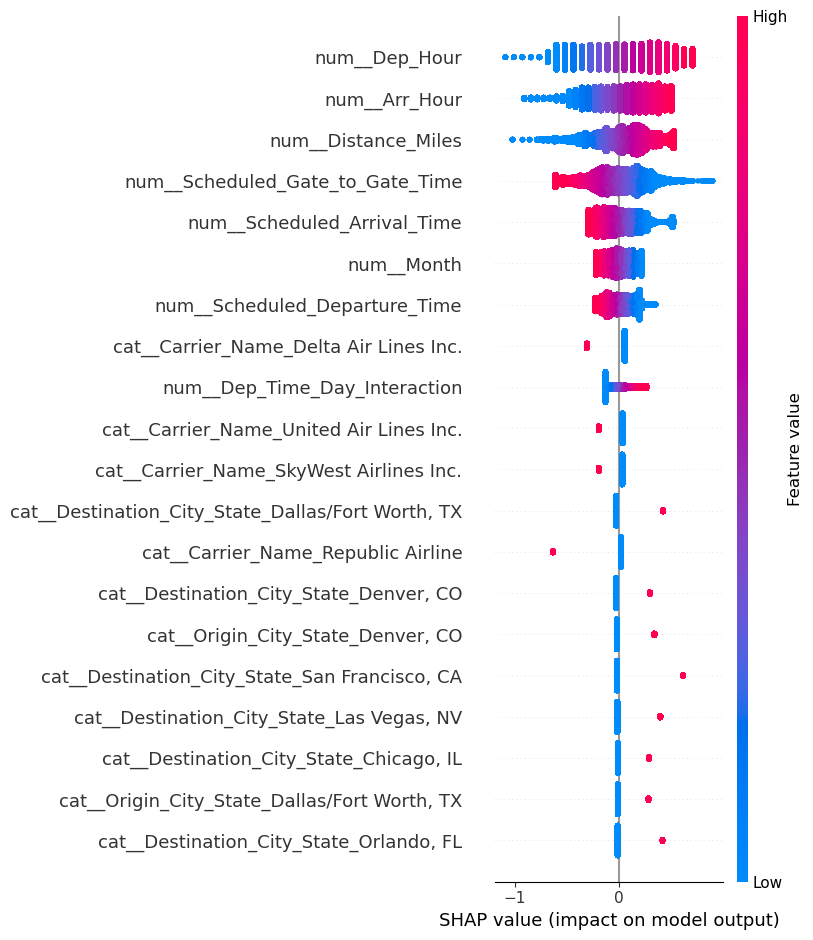

SHAP Summary Plot for Gradient Boosting:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


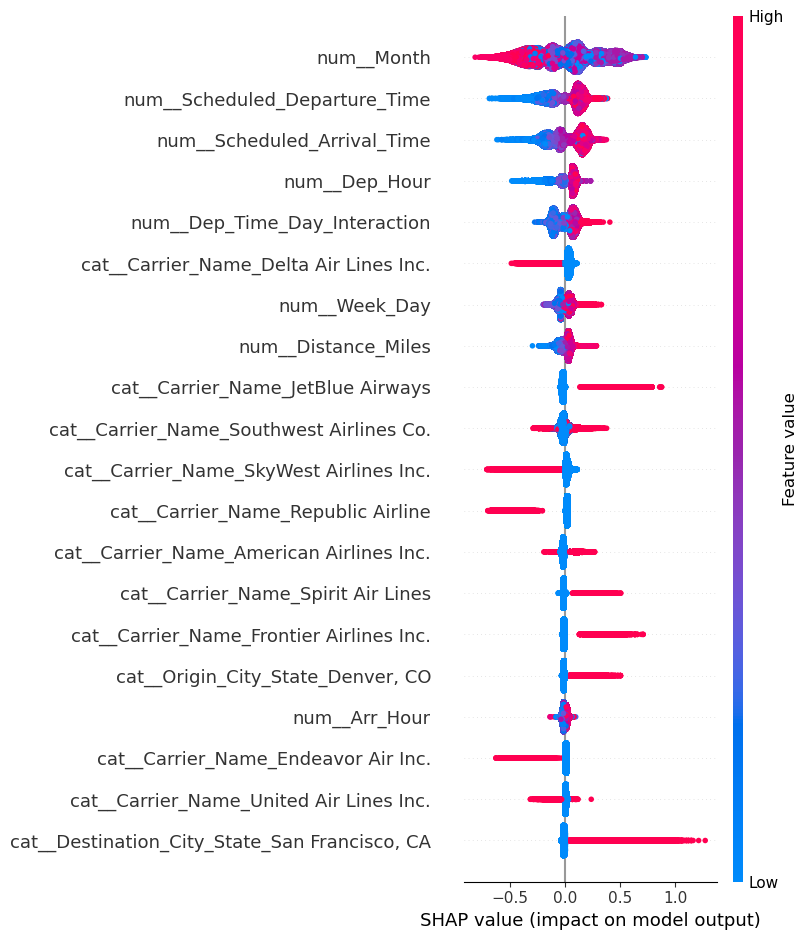

[16:04:23] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


SHAP Summary Plot for XGBoost:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


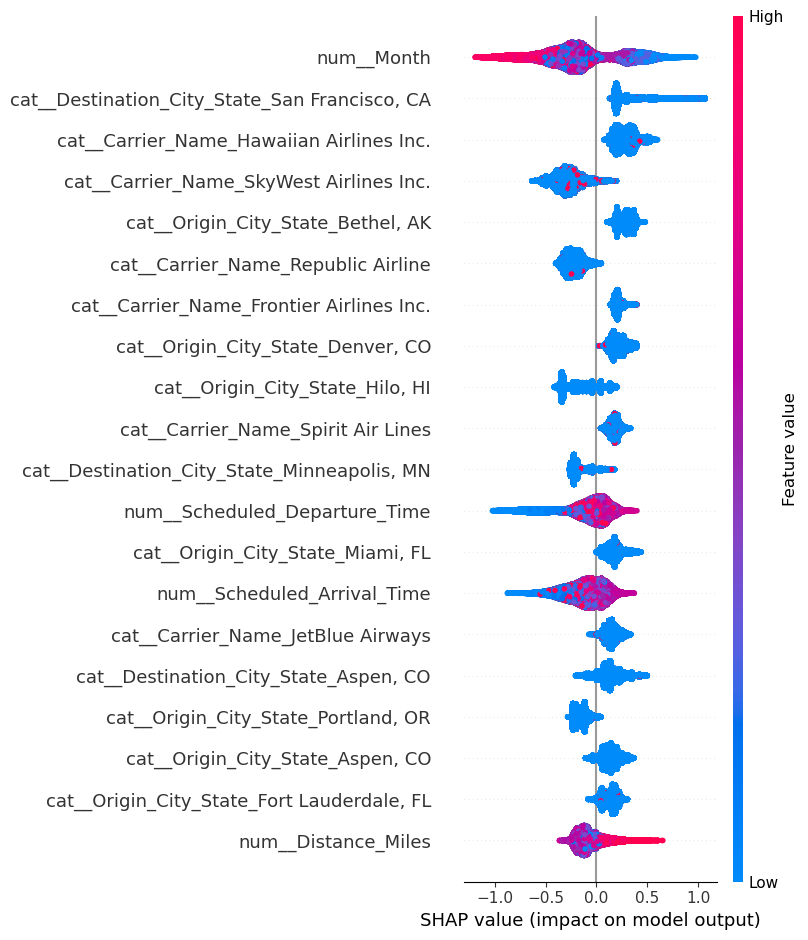

SHAP Summary Plot for LightGBM:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


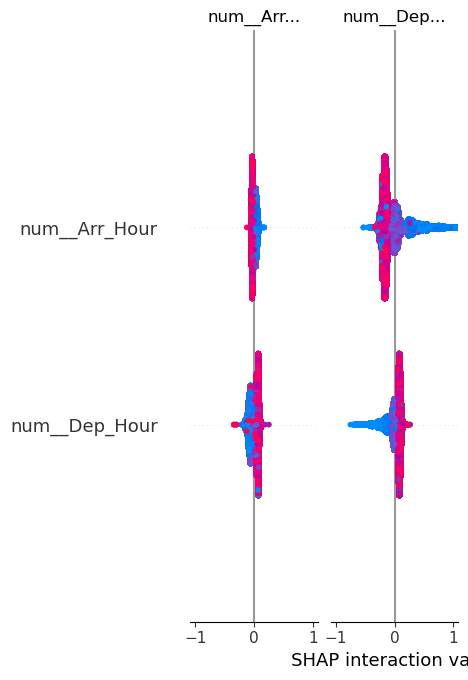

SHAP interpreter took: 2361.209630250931 seconds


In [206]:
import shap
# Use a smaller sample of the test data
X_test_sample = X_test_preprocessed[:1000]

start_time = time.time()

# SHAP for RandomForest
explainer_rf = shap.Explainer(rf_model_best)
shap_values_rf = explainer_rf(X_test_preprocessed)

# Plot SHAP summary plot for RandomForest
print("SHAP Summary Plot for RandomForest:")
shap.summary_plot(shap_values_rf, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

# SHAP for Logistic Regression
explainer_lr = shap.LinearExplainer(lr_model_best, X_train_preprocessed)
shap_values_lr = explainer_lr.shap_values(X_test_preprocessed)

# Plot SHAP summary plot for Logistic Regression
print("SHAP Summary Plot for Logistic Regression:")
shap.summary_plot(shap_values_lr, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

# SHAP for Gradient Boosting
explainer_gb = shap.Explainer(gb_model_best)
shap_values_gb = explainer_gb(X_test_preprocessed)

# Plot SHAP summary plot for Gradient Boosting
print("SHAP Summary Plot for Gradient Boosting:")
shap.summary_plot(shap_values_gb, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

# SHAP for XGBoost
explainer_xgb = shap.Explainer(xgb_model_best)
shap_values_xgb = explainer_xgb(X_test_preprocessed)

# Plot SHAP summary plot for XGBoost
print("SHAP Summary Plot for XGBoost:")
shap.summary_plot(shap_values_xgb, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

# SHAP for LightGBM
explainer_lgb = shap.Explainer(lgb_model_best)
shap_values_lgb = explainer_lgb(X_test_preprocessed)

# Plot SHAP summary plot for LightGBM
print("SHAP Summary Plot for LightGBM:")
shap.summary_plot(shap_values_lgb, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

print("SHAP interpreter took: %s seconds" % (time.time() - start_time))

### Save best model for deployment

In [210]:
import joblib

# Load the best model from the file
loaded_model = joblib.load('GradientBoosting_best_model.pkl')

# Test the loaded model with a sample input
sample_input = X_test[:5]  
sample_prediction = loaded_model.predict(sample_input)
print("Sample predictions from the loaded model:", sample_prediction)

# Check prediction probabilities if relevant for your deployment
sample_prediction_proba = loaded_model.predict_proba(sample_input)
print("Sample prediction probabilities from the loaded model:", sample_prediction_proba)

Sample predictions from the loaded model: [0 1 1 1 1]
Sample prediction probabilities from the loaded model: [[0.61402633 0.38597367]
 [0.46058029 0.53941971]
 [0.42817075 0.57182925]
 [0.48793105 0.51206895]
 [0.12493605 0.87506395]]
